In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
# Importing all necessary libraries

%load_ext autoreload
%autoreload 2

# internal packages
import os
from collections import Counter
# external packages
import torch
import torchvision
import numpy as np
import sklearn
from sklearn.metrics import normalized_mutual_info_score
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
import pandas as pd
import clustpy
from clustpy.deep import encode_batchwise, get_dataloader
from clustpy.alternative import NrKmeans
from clustpy.metrics.multipe_labelings_scoring import MultipleLabelingsConfusionMatrix
import joblib 

# specify base paths

base_path = "/mnt/data/miklautzl92dm_data/clustpy/material"
model_name = "acedec_convae.pth"

print("Versions")
print("torch: ",torch.__version__)
print("torchvision: ",torchvision.__version__)
print("numpy: ", np.__version__)
print("scikit-learn:", sklearn.__version__)
print("clustpy:", clustpy.__version__)

Versions
torch:  2.0.1
torchvision:  0.15.2
numpy:  1.25.0
scikit-learn: 1.3.0rc1
clustpy: 0.0.2-alpha


In [3]:
# Some helper functions, you can ignore those in the beginning
def denormalize_fn(array:np.array, mean:float, std:float, w:int, h:int,c=1)->torch.Tensor:
    """
    This applies an inverse z-transformation and reshaping to visualize the images properly.
    """
    tensor = torch.from_numpy(array).float()
    pt_std = torch.as_tensor(std, dtype=torch.float32, device=tensor.device)
    pt_mean = torch.as_tensor(mean, dtype=torch.float32, device=tensor.device)
    return (tensor.mul(pt_std).add(pt_mean).view(-1, c, h, w) * 255).int().detach()

def plot_images(images:torch.Tensor, pad:int=1):
    """Aligns multiple images on an N by 8 grid"""
    def imshow(img):
        plt.figure(figsize=(10, 20))
        npimg = img.numpy()
        npimg = np.array(npimg)
        plt.axis('off')
        plt.imshow(np.transpose(npimg, (1, 2, 0)),
                   vmin=0, vmax=1)
    
    imshow(torchvision.utils.make_grid(images, pad_value=255, normalize=False, padding=pad))
    plt.show()
    
def detect_device():
    """Automatically detects if you have a cuda enabled GPU"""
    if torch.cuda.is_available():
        device = torch.device('cuda:1')
    else:
        device = torch.device('cpu')
    return device

# Implementation of Data Set with Augmentation With Example for MNIST

In [4]:
from clustpy.data import load_mnist


# load data   
data, labels = load_mnist()
data = data.reshape(-1, 1, 28, 28)
data = torch.from_numpy(data).float()
data = data.repeat(1,3,1,1)
padding_fn = torchvision.transforms.Pad([2,2], fill=0)
data = padding_fn(data)
data /= 255.0

mean = data.mean()
std = data.std()
denormalize = lambda x: denormalize_fn(x, mean=mean, std=std, w=32, h=32, c=3)


# preprocessing functions
normalize_fn = torchvision.transforms.Normalize([mean], [std])
flatten_fn = torchvision.transforms.Lambda(torch.flatten)

# augmentation transforms
transform_list = [
    torchvision.transforms.ToPILImage(),
    # Perform it before cropping causes more computational overhead, but produces less artifacts
    torchvision.transforms.RandomAffine(degrees=(-16,+16),
                                                translate=(0.1, 0.1),
                                                shear=(-8, 8),
                                                fill=0),
    torchvision.transforms.ToTensor(),
    normalize_fn,
]

aug_transforms = torchvision.transforms.Compose(transform_list)
orig_transforms = torchvision.transforms.Compose([normalize_fn])

# pass transforms to dataloader
aug_dl = get_dataloader(data, batch_size=32, shuffle=False, 
                        ds_kwargs={"aug_transforms_list":[aug_transforms], "orig_transforms_list":[orig_transforms]},
                        )

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Plot some images to see if everything worked:


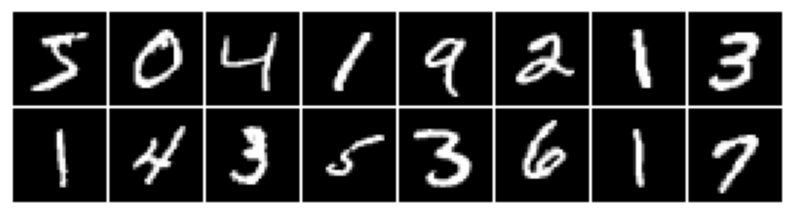

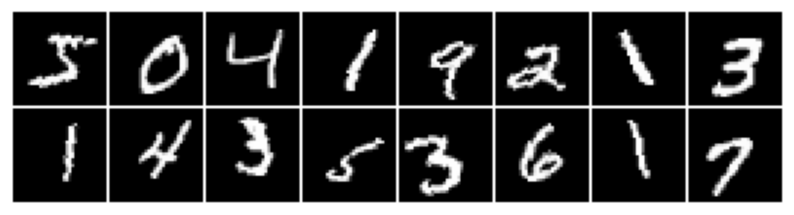

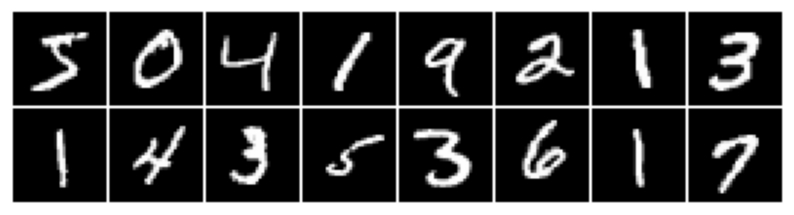

In [5]:
print("Plot some images to see if everything worked:")

plot_images(data[0:16])
for aug_batch in aug_dl:
    break
plot_images(denormalize(aug_batch[1][0:16].numpy()))
plot_images(denormalize(aug_batch[2][0:16].numpy()))

# Pretrain Autoencoder

In [6]:
from clustpy.deep.autoencoders import ConvolutionalAutoencoder

device = torch.device("cuda:0")
model_path = os.path.join(base_path, model_name)
ae = ConvolutionalAutoencoder(32, [512, 10], conv_encoder_name="resnet18").to(device)

In [7]:
# Only used to get a parameter count of the used backbone model
# Can be installed with
# pip install torchinfo or conda install -c conda-forge torchinfo
# Github link: https://github.com/TylerYep/torchinfo

from torchinfo import summary
summary(ae, input_size=(1, 3, 32, 32))

/mnt/data/miklautzl92dm_data/anaconda/envs/clustpydev/lib/python3.9/site-packages/torch/nn/modules/conv.py:459: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at /opt/conda/conda-bld/pytorch_1682343997789/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv2d(input, weight, bias, self.stride,


Layer (type:depth-idx)                             Output Shape              Param #
ConvolutionalAutoencoder                           [1, 3, 32, 32]            --
├─ResNetEncoder: 1-1                               [1, 512]                  --
│    └─Conv2d: 2-1                                 [1, 64, 16, 16]           9,408
│    └─BatchNorm2d: 2-2                            [1, 64, 16, 16]           128
│    └─ReLU: 2-3                                   [1, 64, 16, 16]           --
│    └─MaxPool2d: 2-4                              [1, 64, 8, 8]             --
│    └─Sequential: 2-5                             [1, 64, 8, 8]             --
│    │    └─EncoderBlock: 3-1                      [1, 64, 8, 8]             73,984
│    │    └─EncoderBlock: 3-2                      [1, 64, 8, 8]             73,984
│    └─Sequential: 2-6                             [1, 128, 4, 4]            --
│    │    └─EncoderBlock: 3-3                      [1, 128, 4, 4]            230,144
│    │    └─Encode

In [8]:
# install pytorch_warmup from https://pypi.org/project/pytorch-warmup/
# with
# pip install -U pytorch_warmup
import pytorch_warmup as warmup
from torch.optim.lr_scheduler import CosineAnnealingLR

class CosineSchedulerWithLinearWarmup(object):
    def __init__(self, optimizer, warmup_period, T_max, eta_min=0, last_epoch=-1, verbose=False):
        self.T_max = T_max
        self.eta_min = eta_min
        self.warmup_period = warmup_period
        self.warmup_scheduler = warmup.LinearWarmup(optimizer, warmup_period=warmup_period)
        self.cosine_scheduler =  CosineAnnealingLR(optimizer, T_max=T_max, eta_min=eta_min, last_epoch=last_epoch, verbose=verbose)       
    def step(self):
        with self.warmup_scheduler.dampening():
            self.cosine_scheduler.step()

In [9]:
aug_train_dl = get_dataloader(data, batch_size=256, shuffle=True, 
                        ds_kwargs={"aug_transforms_list":[aug_transforms], "orig_transforms_list":[orig_transforms]},
                        dl_kwargs={"num_workers":16})

train_dl = get_dataloader(data, batch_size=256, shuffle=True, 
                        ds_kwargs={"orig_transforms_list":[orig_transforms]},
                        dl_kwargs={"num_workers":16})


In [10]:
TRAIN = False
weight_decay = 0.01
ae_lr = 1e-3
if TRAIN:
    n_epochs = 50
    warmup_factor = 0.3
    warmup_period = int(warmup_factor*n_epochs)
    scheduler = CosineSchedulerWithLinearWarmup
    scheduler_params = {"warmup_period":warmup_period, "T_max":n_epochs, "verbose":True}
    ae.fit(n_epochs=n_epochs, optimizer_params={"lr":ae_lr}, 
           # uncomment if augmentation should be used during pretraining
           dataloader=aug_train_dl,
#            dataloader=train_dl,
           device=device, print_step=5, model_path=model_path,
           optimizer_class=lambda params, lr: torch.optim.AdamW(params, lr, weight_decay=weight_decay), scheduler=scheduler, scheduler_params=scheduler_params)
else:
    sd = torch.load(model_path)
    ae.load_state_dict(sd)
    ae.fitted = True

In [11]:
from clustpy.deep import encode_decode_batchwise

dl = get_dataloader(data, 256, shuffle=False,
                   ds_kwargs={"orig_transforms_list":[orig_transforms]})

emb, rec = encode_decode_batchwise(dl, ae, device)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


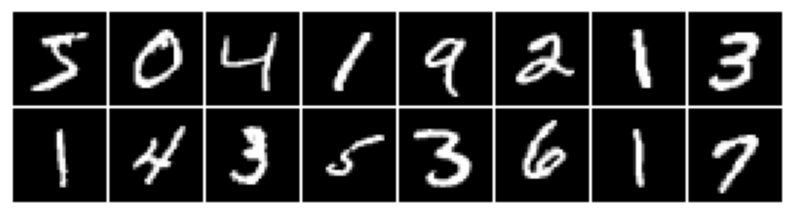

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


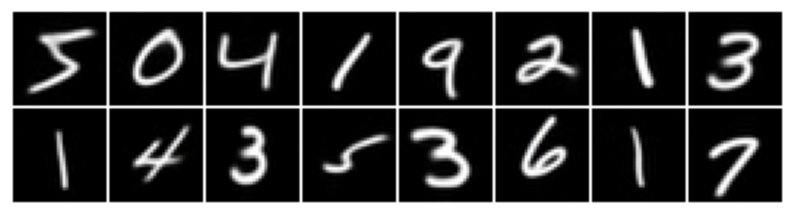

In [12]:
plot_images(data[0:16])
plot_images(denormalize(rec[0:16]))

In [13]:
from sklearn.metrics import adjusted_rand_score as ari

from sklearn.cluster import KMeans

kmeans = KMeans(10)
kmeans.fit(emb)
km_ari = ari(labels, kmeans.labels_)
print(f"ARI: {km_ari}")

/export/home/miklautzl92dm/.local/lib/python3.9/site-packages/scikit_learn-1.3.0rc1-py3.9-linux-x86_64.egg/sklearn/cluster/_kmeans.py:1421: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


ARI: 0.708998073961738


# Apply ACeDeC without augmentation and without invariance

Custom dataloaders are used, X will be overwritten with testloader return values.
Setup autoencoder
Run init:  acedec
Start encoding
Start initializing parameters
Start ACeDeC init
Start with random init
mdl_for_noisespace=True, because number of clusters is larger then data dimensionality
Round 0: Found solution with: 2219581.5970701603 (current best: 2219581.5970701603)
Round 1: Found solution with: 2082758.443381616 (current best: 2082758.443381616)
Round 2: Found solution with: 2199695.0646158545 (current best: 2082758.443381616)
Round 3: Found solution with: 2387923.4757325863 (current best: 2082758.443381616)
Round 4: Found solution with: 2146682.102111466 (current best: 2082758.443381616)
Round 5: Found solution with: 2192784.033513115 (current best: 2082758.443381616)
Round 6: Found solution with: 2193377.3185956525 (current best: 2082758.443381616)
Round 7: Found solution with: 2204957.567653383 (current best: 2082758.443381616)
Round 8: Found solution with: 2206680.2692228165

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Betas after reclustering
[[0.5782704  0.5588837  0.6700329  0.7530574  0.9338496  0.9502628
  0.90485185 0.9717899  0.5461215  0.61399335]
 [0.42172962 0.4411162  0.32996708 0.24694256 0.06615044 0.04973721
  0.0951482  0.02821006 0.45387852 0.38600665]]
ARI: 0.8042115678289046
ARI-no-reclustering: 0.7082881406855792


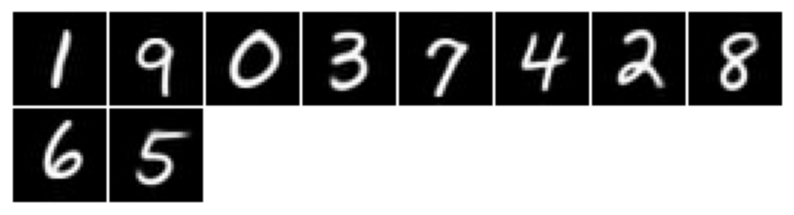

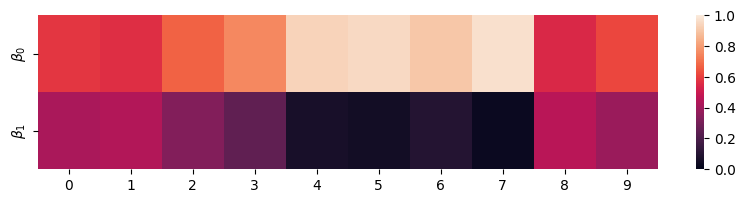

In [14]:
from clustpy.deep import ACeDeC

sd = torch.load(model_path)
ae.load_state_dict(sd)
ae.to(device)

clustering_epochs = 100
warmup_factor = 0.3
warmup_period = int(warmup_factor*clustering_epochs)
# scheduler = CosineSchedulerWithLinearWarmup
# scheduler_params = {"warmup_period":warmup_period, "T_max":clustering_epochs, "verbose":False}
scheduler = torch.optim.lr_scheduler.StepLR
scheduler_params = {"step_size":int(0.2*clustering_epochs), "gamma":0.5, "verbose": True}



acedec = ACeDeC(n_clusters=10,
          clustering_epochs=clustering_epochs,
          autoencoder=ae,
          clustering_optimizer_params={'lr': ae_lr*0.5},
          custom_dataloaders=[train_dl, dl],
          scheduler=scheduler,
          scheduler_params=scheduler_params,
          final_reclustering=True,
          debug=True,
          init_subsample_size=10000,
          )
acedec.fit(data)
acedec_ari = ari(labels, acedec.labels_)
print(f"ARI: {acedec_ari}")
print(f"ARI-no-reclustering: {ari(labels, acedec.acedec_labels_)}")
rec_centers = acedec.reconstruct_subspace_centroids()
plot_images(denormalize(rec_centers))

# Soft Beta Weights
fig, ax = plt.subplots(figsize=(10,2))
sns.heatmap(acedec.betas, vmin=0, vmax=1.0, ax=ax)
ax.set_yticklabels(["$\\beta_0$", "$\\beta_1$"])
plt.show();


In [15]:
cluster_labels = acedec.predict(X=None, dataloader=dl, use_P=False)
acedec_ari2 = ari(labels, cluster_labels)
print(f"ARI: {acedec_ari2}")

ARI: 0.8076011124395857


# Apply AceDec With Augmentation With Invariance

Custom dataloaders are used, X will be overwritten with testloader return values.
Setup autoencoder
Run init:  acedec
Start encoding
Start initializing parameters
Start ACeDeC init
Start with random init
mdl_for_noisespace=True, because number of clusters is larger then data dimensionality
Round 0: Found solution with: 2464653.0903273253 (current best: 2464653.0903273253)
Round 1: Found solution with: 2202834.1895394316 (current best: 2202834.1895394316)
Round 2: Found solution with: 2165640.943897451 (current best: 2165640.943897451)
Round 3: Found solution with: 2443980.8858087324 (current best: 2165640.943897451)
Round 4: Found solution with: 2304808.888647724 (current best: 2165640.943897451)
Round 5: Found solution with: 2164119.34004466 (current best: 2164119.34004466)
Round 6: Found solution with: 2143320.906532601 (current best: 2143320.906532601)
Round 7: Found solution with: 2453628.281716015 (current best: 2143320.906532601)
Round 8: Found solution with: 2280839.952691829 (c

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Betas after reclustering
[[0.7223945  0.9909406  0.89713407 0.58454996 0.52684027 0.94096255
  0.5466969  0.64888984 0.5546838  0.97430295]
 [0.27760547 0.00905951 0.10286599 0.41545004 0.4731597  0.05903747
  0.4533031  0.35111013 0.4453162  0.02569712]]
ARI: 0.9012325266812274
ARI-no-reclustering: 0.8964103092907963


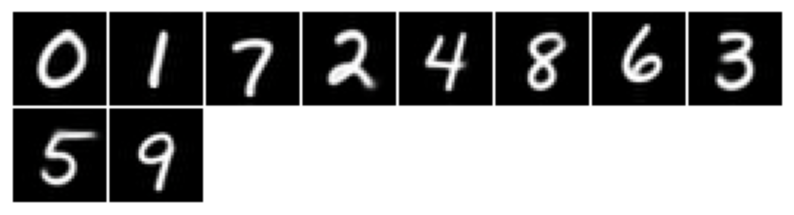

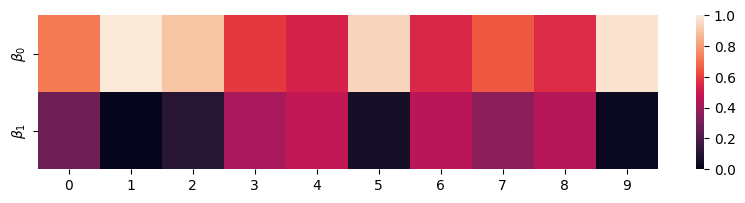

In [16]:
from clustpy.deep import ACeDeC

sd = torch.load(model_path)
ae.load_state_dict(sd)
ae.to(device)

clustering_epochs = 100
warmup_factor = 0.3
warmup_period = int(warmup_factor*clustering_epochs)
# scheduler = CosineSchedulerWithLinearWarmup
# scheduler_params = {"warmup_period":warmup_period, "T_max":clustering_epochs, "verbose":False}
scheduler = torch.optim.lr_scheduler.StepLR
scheduler_params = {"step_size":int(0.2*clustering_epochs), "gamma":0.5, "verbose": True}


acedec = ACeDeC(n_clusters=10,
          clustering_epochs=clustering_epochs,
          autoencoder=ae,
          clustering_optimizer_params={'lr': ae_lr*0.5},
          custom_dataloaders=[aug_train_dl, dl],
          scheduler=scheduler,
          scheduler_params=scheduler_params,
          augmentation_invariance=True,
          final_reclustering=True,
          debug=True,
          init_subsample_size=10000,
          )
acedec.fit(data)
acedec_ari = ari(labels, acedec.labels_)
print(f"ARI: {acedec_ari}")
print(f"ARI-no-reclustering: {ari(labels, acedec.acedec_labels_)}")
rec_centers = acedec.reconstruct_subspace_centroids()
plot_images(denormalize(rec_centers))

# Soft Beta Weights
fig, ax = plt.subplots(figsize=(10,2))
sns.heatmap(acedec.betas, vmin=0, vmax=1.0, ax=ax)
ax.set_yticklabels(["$\\beta_0$", "$\\beta_1$"])
plt.show();


In [17]:
cluster_labels = acedec.predict(X=None, dataloader=dl, use_P=False)
acedec_ari2 = ari(labels, cluster_labels)
print(f"ARI: {acedec_ari2}")

ARI: 0.8882379398588801
